In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
!pip install surprise
import csv
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from surprise import Reader
from surprise import Dataset
from surprise import accuracy

from collections import defaultdict
from surprise.model_selection import train_test_split



from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore

In [3]:
#This file contains information about music artists listened and tagged by the users.
artists = pd.read_table('/content/drive/MyDrive/RS/LA_04_Dataset/artists.dat', sep="\t")
user_artists = pd.read_table('/content/drive/MyDrive/RS/LA_04_Dataset/user_artists.dat', sep="\t")

In [23]:
range_scaler = MinMaxScaler(feature_range=(1,5))
user_artists['ratings'] = range_scaler.fit_transform(user_artists.weight.values.reshape(-1,1))
user_artists

,userID,artistID,weight,ratings
0,2,51,13883,1.157438
1,2,52,11690,1.132567
2,2,53,11351,1.128722
3,2,54,10300,1.116803
4,2,55,8983,1.101866
...,...,...,...,...
92829,2100,18726,337,1.003811
92830,2100,18727,297,1.003357
92831,2100,18728,281,1.003176
92832,2100,18729,280,1.003164


In [5]:
tags = pd.read_table('/content/drive/MyDrive/RS/LA_04_Dataset/tags.dat', sep="\t", encoding='latin-1')
tags


,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


In [6]:
user_friends = pd.read_table('/content/drive/MyDrive/RS/LA_04_Dataset/user_friends.dat', sep="\t", encoding='latin-1')
user_friends

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


In [7]:
user_taggedartists = pd.read_table('/content/drive/MyDrive/RS/LA_04_Dataset/user_taggedartists.dat', sep="\t")
user_taggedartists

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


In [8]:
user_artists.head()

,userID,artistID,weight,ratings
0,2,51,13883,1.157438
1,2,52,11690,1.132567
2,2,53,11351,1.128722
3,2,54,10300,1.116803
4,2,55,8983,1.101866


In [9]:
artists

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda Galás,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [10]:
user_artists['ratings'].describe()

count    92834.000000
mean         1.008441
std          0.042544
min          1.000000
25%          1.001202
50%          1.002937
75%          1.006952
max          5.000000
Name: ratings, dtype: float64

#DATASET ANALYSIS 


#Question 1

In [57]:
ratings = user_artists[["userID","artistID", "ratings"]].rename(columns={'ratings':'rating'})
ratings

,userID,artistID,rating
0,2,51,1.157438
1,2,52,1.132567
2,2,53,1.128722
3,2,54,1.116803
4,2,55,1.101866
...,...,...,...
92829,2100,18726,1.003811
92830,2100,18727,1.003357
92831,2100,18728,1.003176
92832,2100,18729,1.003164


In [12]:
print("No. of users : " , len(np.unique(ratings["userID"])))


No. of users :  1892


In [13]:
print("No. of artists : " , len(np.unique(ratings["artistID"])))


No. of artists :  17632


##### Per Artist -> Count | Max_rating | Min_rating | Avg_rating

In [14]:
per_artist_rating_count = pd.DataFrame(ratings.groupby('artistID')['rating'].count(), columns=["rating"] )
per_artist_rating_count=per_artist_rating_count.rename(columns={'rating':'rating_count'})


In [15]:
per_artist_rating_max = pd.DataFrame(ratings.groupby('artistID')['rating'].max(), columns=["rating"] )
per_artist_rating_max=per_artist_rating_max.rename(columns={'rating':'max_rating'})


In [16]:
per_artist_rating_min = pd.DataFrame(ratings.groupby('artistID')['rating'].min(), columns=["rating"] )
per_artist_rating_min=per_artist_rating_min.rename(columns={'rating':'min_rating'})


In [17]:
per_artist_rating_avg = pd.DataFrame(ratings.groupby('artistID')['rating'].mean(), columns=["rating"] )
per_artist_rating_avg=per_artist_rating_avg.rename(columns={'rating':'avg_rating'})


In [18]:
artist_summary_df = per_artist_rating_count.merge(per_artist_rating_max,on='artistID')\
                    .merge(per_artist_rating_min,on='artistID')\
                    .merge(per_artist_rating_avg,on='artistID')
artist_summary_df

,rating_count,max_rating,min_rating,avg_rating
artistID,,,,
1,3,1.005466,1.000851,1.002903
2,12,1.039297,1.000624,1.007561
3,3,1.004616,1.000408,1.002918
4,2,1.006362,1.000000,1.003181
5,2,1.007394,1.002937,1.005166
...,...,...,...,...
18741,1,1.003402,1.003402,1.003402
18742,1,1.003323,1.003323,1.003323
18743,1,1.003244,1.003244,1.003244


##### 5 Most Rated artist

In [19]:
print(per_artist_rating_count.sort_values('rating_count', ascending=False ).head(5))

          rating_count
artistID              
89                 611
289                522
288                484
227                480
300                473


##### 5 least Rated artists

In [20]:
print(per_artist_rating_count.sort_values('rating_count', ascending=True ).head(5))

          rating_count
artistID              
18745                1
7568                 1
7569                 1
7570                 1
7571                 1


### Rating Distribution Plot

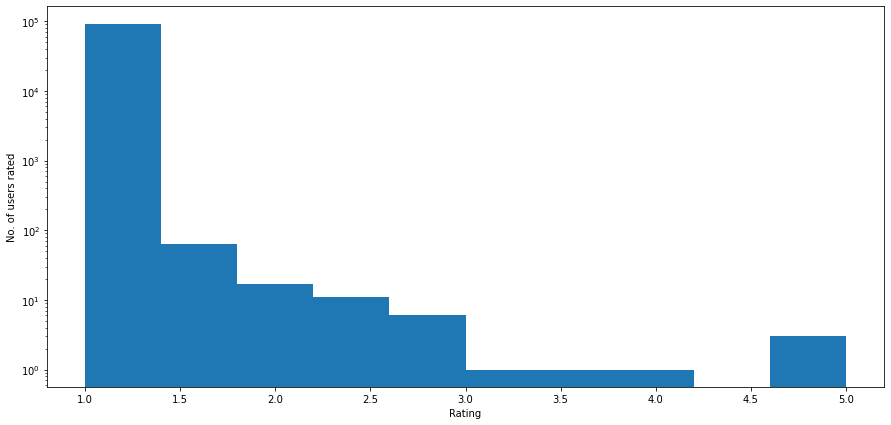

In [21]:
plt.figure(figsize=(15, 7))
plt.hist(user_artists['ratings'])
plt.yscale("log")
plt.xlabel('Rating')
plt.ylabel('No. of users rated')
plt.show()

#EXPLAINING RECOMMENDATIONS 

#Question 2

In [32]:
user_item_ratings_matrix = user_artists.pivot(index='userID', columns='artistID', values='ratings').fillna(0)
our_user_ids = user_item_ratings_matrix.index
our_artists_ids = user_item_ratings_matrix.columns

print(user_item_ratings_matrix)

artistID  1      2         3      4      5        6      7      8      9      \
userID                                                                         
2           0.0    0.0  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0   
3           0.0    0.0  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0   
4           0.0    0.0  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0   
5           0.0    0.0  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0   
6           0.0    0.0  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0   
...         ...    ...       ...    ...    ...      ...    ...    ...    ...   
2095        0.0    0.0  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0   
2096        0.0    0.0  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0   
2097        0.0    0.0  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0   
2099        0.0    0.0  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0   
2100        0.0    0.0  1.004616    0.0 

In [33]:
R = Reader(rating_scale=(1,5))
user_artist_dataset = Dataset.load_from_df(user_artists[['userID','artistID','ratings']], R)
user_artist_dataset

train_set, test_set = train_test_split(user_artist_dataset, test_size = 0.2)

knn = KNNWithMeans(k=30, sim_options={'name': 'cosine', 'user_based': True})
knn.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [34]:
ratings_estimated_knn = knn.test(test_set)
ratings_estimated_knn

[Prediction(uid=659, iid=2523, r_ui=1.0097647555834044, est=1.0152633518312495, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=1263, iid=324, r_ui=1.0087780729634785, est=1.0087605569571316, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=1549, iid=226, r_ui=1.000510353079272, est=1.0014900499988928, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=757, iid=257, r_ui=1.0030961420142501, est=1.1389950230517205, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=1083, iid=2544, r_ui=1.009605979069853, est=1.0005681097038888, details={'actual_k': 25, 'was_impossible': False}),
 Prediction(uid=1042, iid=689, r_ui=1.0079728492161828, est=1.009672193070809, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=1106, iid=461, r_ui=1.0817131985812185, est=1.0748288149456255, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=1562, iid=1048, r_ui=1.0049107307405507, est=1.0042620036309255

In [35]:
user_item_ratings_matrix

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2097,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
test_user_cnt = 5
ids_test_users = user_item_ratings_matrix.index[10:10 +test_user_cnt ]
ids_test_users

Int64Index([12, 13, 14, 15, 16], dtype='int64', name='userID')

In [39]:
Similarity_Matrix_test_users_other_users = list()
for u in ids_test_users:
    row_users = user_item_ratings_matrix.loc[u]
    Similarity_Matrix_test_users_other_users.append(user_item_ratings_matrix @ row_users)

print(len(Similarity_Matrix_test_users_other_users))
print(len(Similarity_Matrix_test_users_other_users[0]))

print(Similarity_Matrix_test_users_other_users)
#Converting to dataframe
Similarity_Matrix_test_users_other_users = pd.DataFrame(Similarity_Matrix_test_users_other_users, columns = user_item_ratings_matrix.index, index = ids_test_users)
Similarity_Matrix_test_users_other_users

5
1892
[userID
2       1.054717
3       0.000000
4       3.169050
5       1.025498
6       0.000000
          ...   
2095    0.000000
2096    2.046977
2097    2.070547
2099    1.020352
2100    0.000000
Length: 1892, dtype: float64, userID
2       3.202418
3       0.000000
4       1.003357
5       2.004389
6       0.000000
          ...   
2095    0.000000
2096    2.073698
2097    2.002903
2099    0.000000
2100    0.000000
Length: 1892, dtype: float64, userID
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
       ... 
2095    0.0
2096    0.0
2097    0.0
2099    0.0
2100    0.0
Length: 1892, dtype: float64, userID
2        1.033654
3        0.000000
4        2.029526
5       10.082565
6        1.002961
          ...    
2095     0.000000
2096     4.095035
2097     6.045074
2099     0.000000
2100     0.000000
Length: 1892, dtype: float64, userID
2       1.026999
3       0.000000
4       1.012388
5       0.000000
6       0.000000
          ...   
2095    0.000000
2096    0.0000

userID,2,3,4,5,6,7,8,9,10,11,...,2090,2091,2092,2093,2094,2095,2096,2097,2099,2100
userID,,,,,,,,,,,,,,,,,,,,,
12,1.054717,0.0,3.169050,1.025498,0.000000,3.860612,3.124758,5.091968,0.000000,5.180361,...,0.000000,0.0,1.025695,0.000000,3.167907,0.0,2.046977,2.070547,1.020352,0.0
13,3.202418,0.0,1.003357,2.004389,0.000000,15.384812,9.113589,1.006691,1.003210,10.141825,...,0.000000,0.0,1.010446,0.000000,6.156541,0.0,2.073698,2.002903,0.000000,0.0
14,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,1.010455,0.000000,0.0,0.000000,0.000000,0.000000,0.0
15,1.033654,0.0,2.029526,10.082565,1.002961,0.000000,0.000000,0.000000,3.027078,0.000000,...,1.010165,0.0,4.042938,1.006540,0.000000,0.0,4.095035,6.045074,0.000000,0.0
16,1.026999,0.0,1.012388,0.000000,0.000000,1.076544,2.029038,1.007007,0.000000,1.048354,...,0.000000,0.0,0.000000,0.000000,1.020495,0.0,0.000000,0.000000,0.000000,0.0


In [47]:
neighbors = []
for u in ids_test_users:
    new = Similarity_Matrix_test_users_other_users.loc[u].sort_values(ascending=False)[1:15]
    neighbors.append(new.index)
print(neighbors)

item_cnt=len(np.unique(ratings["artistID"]))

item_list = []
for i in range(len(ids_test_users)):
    sorted_users = neighbors[i]

    user_item_row = np.array([0]*item_cnt)
    for NU in sorted_users:
        user_item_row = user_item_row + np.array(user_item_ratings_matrix.loc[NU])

    item_list.append(list(user_item_row))
print(item_list)

recommeded_items_df = pd.DataFrame(item_list, index = ids_test_users, columns = user_item_ratings_matrix.columns)
#recommeded_items_df

recommendations = []
for i in range(len(ids_test_users)):
    u = ids_test_users[i]
    iid = list(recommeded_items_df.loc[u][recommeded_items_df.loc[u]>0].sort_values(ascending = False).index)
    known = list(user_item_ratings_matrix.loc[2][user_item_ratings_matrix.loc[2]>0].index)
    recommended_items = [item for item in iid if item not in known][0:10]
    recommendations.append(recommended_items)
    print("User id : ", u);
    print("Recommeded items : ",recommended_items )

#print(recommendations)

[Int64Index([1649, 189, 545, 763, 139, 385, 1759, 458, 1157, 1476, 179, 186,
            1935, 1703],
           dtype='int64', name='userID'), Int64Index([339, 132, 1780, 1071, 1821, 1600, 632, 1124, 722, 985, 1511, 226,
            816, 1135],
           dtype='int64', name='userID'), Int64Index([642, 1032, 563, 1357, 1792, 1061, 1224, 1347, 907, 1037, 1889,
            1223, 754, 1073],
           dtype='int64', name='userID'), Int64Index([622, 1518, 1470, 1404, 237, 1295, 1182, 765, 5, 1747, 977, 1832,
            366, 1173],
           dtype='int64', name='userID'), Int64Index([2068, 1017, 354, 1567, 415, 1577, 1263, 252, 248, 984, 732, 592,
            851, 45],
           dtype='int64', name='userID')]
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.047258695140588, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.000601082515587, 1

In [77]:
#ratings

User id :  12
Histogram for recommeded item :  486
neighbors_rating_list :  [1.0818492927356909, 1.017851016594981, 1.007621272650462, 1.002222871189718, 1.003719906888916, 1.0291808549548196, 0, 1.0102524263035977, 1.0126113916477884, 1.1052574873049672, 1.0006464472337446, 0, 1.0040601422750972, 1.0032322361687227]


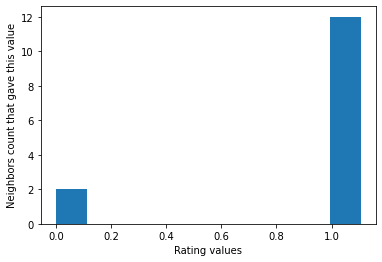

Histogram for recommeded item :  377
neighbors_rating_list :  [1.0067933665440874, 1.0200512054256203, 1.0138589213971199, 1.0072583549052019, 1.0018939769830761, 1.0265497013016838, 1.030961420142502, 0, 0, 1.0134960036518599, 1.025744477554388, 1.0008279061063745, 1.0033796715027345, 1.0020527534966275]


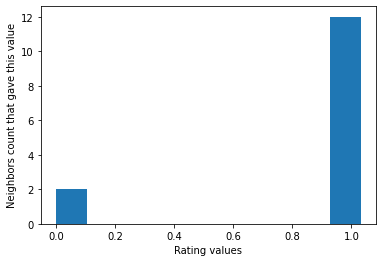

Histogram for recommeded item :  498
neighbors_rating_list :  [1.0068614136213236, 1.0189057462921431, 1.0047632954065389, 1.0018599534444579, 1.0327533265097237, 1.2718367323793511, 0, 1.0018939769830761, 0, 1.043799635381078, 1.000782541388217, 1.012747485802261, 1.0357473979081195, 0]


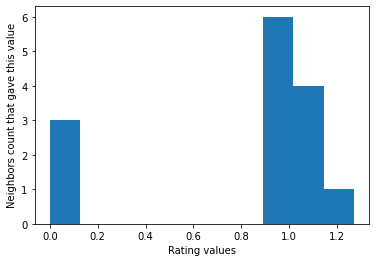

Histogram for recommeded item :  378
neighbors_rating_list :  [1.0525096612673202, 1.0098781673787982, 1.0070428724939537, 1.0015650827764342, 1.0026311536531356, 0, 0, 1.000839247285914, 1.0031415067324077, 0, 1.000964000260847, 1.0563996858493268, 1.012089697388977, 1.0012815532879498]


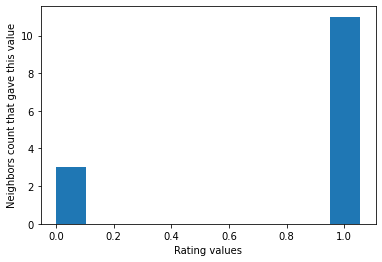

Histogram for recommeded item :  190
neighbors_rating_list :  [0, 1.0106947323056334, 1.011431908975693, 1.0017011769309068, 1.0010433885176229, 1.0117721443618743, 0, 1.003810636325231, 0, 1.0425294232726674, 0, 1.000090729436315, 0, 0]


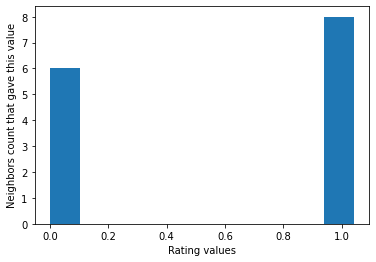

Histogram for recommeded item :  7
neighbors_rating_list :  [1.0179304048517566, 1.0062603311057365, 1.0035271068367466, 1.00200738877847, 1.0043550129431211, 0, 1.0066459312100755, 0, 1.003481742118589, 0, 1.0030507772960926, 0, 0, 0]


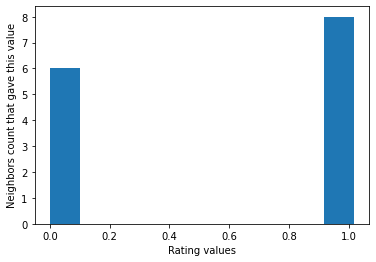

Histogram for recommeded item :  518
neighbors_rating_list :  [1.005818025103701, 0, 1.0055571779742951, 1.001803247546761, 1.0017805651876823, 1.0072583549052019, 0, 1.0007712002086777, 0, 0, 0, 1.0034023538618133, 0, 1.0011908238516347]


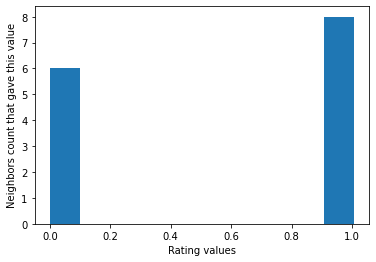

Histogram for recommeded item :  291
neighbors_rating_list :  [1.0072243313665838, 0, 1.0033796715027345, 0, 0, 1.075725055784427, 0, 0, 0, 1.0125887092887096, 1.0026765183712931, 1.006362401721591, 0, 1.0033116244254983]


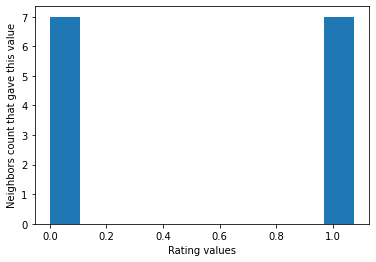

Histogram for recommeded item :  333
neighbors_rating_list :  [0, 0, 1.0044457423794362, 0, 1.0013609415447253, 1.0188717227535249, 0, 1.0006237648746659, 0, 1.0053530367425865, 1.0027105419099114, 1.0746136201895677, 0, 0]


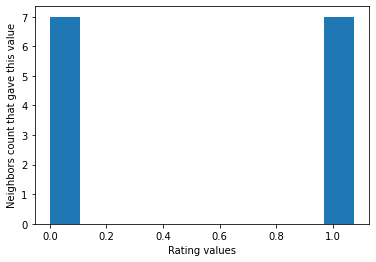

Histogram for recommeded item :  1854
neighbors_rating_list :  [1.0219565235882357, 1.0033683303231953, 1.0041281893523335, 1.0032776008868802, 0, 0, 0, 0, 1.0082677198842065, 0, 0, 0, 1.0089595318361086, 1.0507858019773346]


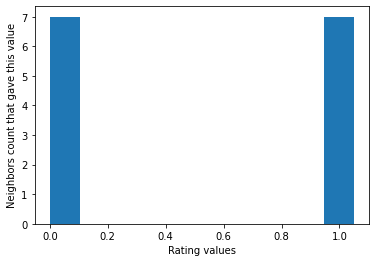




User id :  13
Histogram for recommeded item :  288
neighbors_rating_list :  [1.040714834546367, 1.0375279630958019, 1.0359288567807494, 1.0266971366356958, 1.0087440494248605, 1.0155260747894084, 1.0179530872108353, 1.0275817486397674, 1.0107968029214878, 1.073264019824382, 1.0064531311579061, 1.2102427863009892, 1.0003402353861814, 1.0212987351749518]


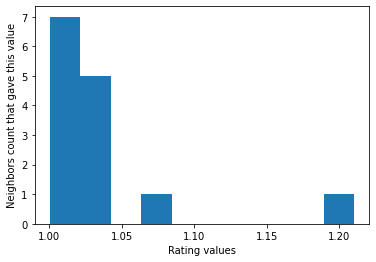

Histogram for recommeded item :  295
neighbors_rating_list :  [1.0380269749955344, 1.0173860282338665, 1.017941746031296, 1.018928428651222, 1.0021548241124818, 1.0018145887263006, 1.0310748319378957, 1.0150270628896758, 1.0017805651876823, 1.0706215249917068, 1.0031528479119471, 1.0096173202493925, 1.0001701176930906, 1.0144373215536282]


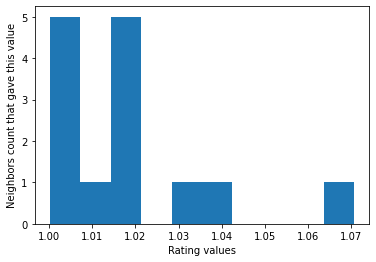

Histogram for recommeded item :  300
neighbors_rating_list :  [1.0205275349662741, 1.0116360502074018, 1.0194047581918757, 1.0203233937345653, 1.0099235320969557, 1.006600566491918, 1.0062603311057365, 1.0075532255732258, 1.0093111084018294, 1.015628145405263, 1.0518291904949575, 1.0166148280251888, 1.0001360941544726, 1.0121577444662133]


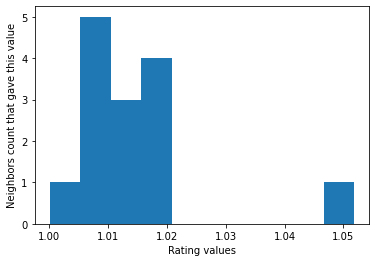

Histogram for recommeded item :  292
neighbors_rating_list :  [1.050558978386547, 0, 1.0595185102226556, 1.2317570038871892, 1.0173973694134057, 1.0376980807888925, 1.0461699419048078, 1.0094358613767624, 1.0181458872630047, 1.2628091534660062, 1.0785376683101926, 1.007621272650462, 1.0001474353340118, 1.0290220784412683]


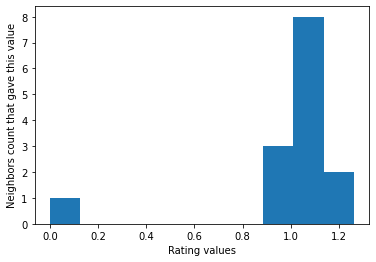

Histogram for recommeded item :  289
neighbors_rating_list :  [1.1557597597938174, 1.0056025426924526, 1.091659413037253, 1.0501280135640507, 1.0496290016643182, 1.031596526196707, 1.1445433332293726, 1.0468617538567098, 1.0472813774996668, 0, 1.019654264141742, 1.0013155768265678, 1.0001134117953938, 1.0118742149777287]


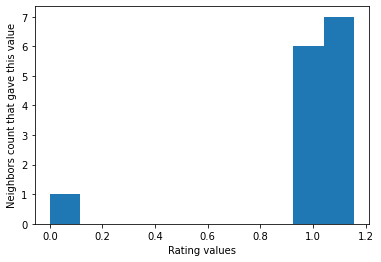

Histogram for recommeded item :  466
neighbors_rating_list :  [1.0063170370034336, 1.0028012713462264, 1.043867682458314, 1.0077006609072376, 1.0058293662832403, 1.0205728996844317, 1.0788325389782165, 1.0106040028693184, 1.0133939330360053, 0, 1.0071789666484263, 1.0101276733286646, 1.0002154824112481, 1.0146868275034946]


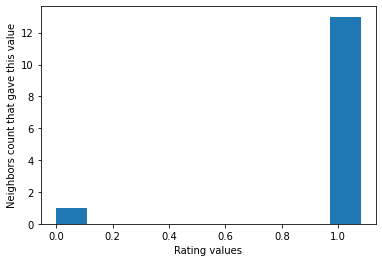

Histogram for recommeded item :  701
neighbors_rating_list :  [1.0609588400241567, 1.0033229656050378, 1.0018939769830761, 1.011522638412008, 1.0069408018780994, 1.0060788722331067, 1.0104225439966883, 1.0369835864779116, 1.0037085657093765, 1.0526911201399503, 0, 1.0196769465008209, 1.0000680470772363, 1.0001701176930906]


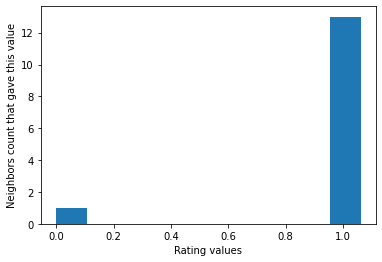

Histogram for recommeded item :  325
neighbors_rating_list :  [1.0177149224405084, 1.0050808484336413, 1.0842422816184998, 1.0024043300623482, 1.0012361885697922, 1.0097534144038651, 1.0050921896131808, 1.0189397698307612, 1.003425036220892, 1.0067480018259298, 0, 1.0125546857500913, 1.0000453647181575, 1.000510353079272]


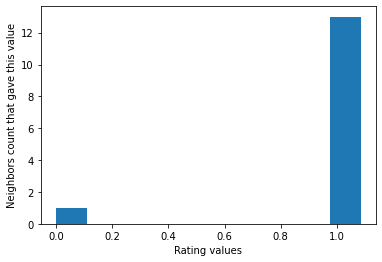

Histogram for recommeded item :  333
neighbors_rating_list :  [1.0129856505725878, 1.0036064950935222, 1.003391012682274, 1.0089481906565692, 1.00237030652373, 1.02826221941213, 1.0094585437358412, 1.0088347788611753, 1.0325491852780149, 1.0123959092365402, 1.0147662157602702, 1.005670589769689, 0, 1.000510353079272]


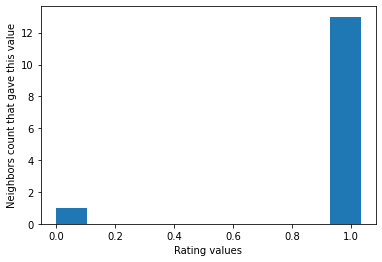

Histogram for recommeded item :  302
neighbors_rating_list :  [1.014641462785337, 1.001916659342155, 1.0068614136213236, 1.0127588269818002, 1.0032889420664197, 1.0117267796437168, 1.0156848513029597, 0, 1.0122371327229889, 1.036779445246203, 1.007950166857104, 1.015424004173554, 1.0000567058976968, 1.0005216942588113]


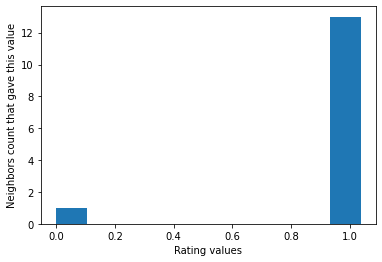




User id :  14
Histogram for recommeded item :  580
neighbors_rating_list :  [1.006509837055603, 1.0019053181626154, 1.0230339356444766, 0, 1.0056819309492284, 1.0030734596551714, 1.0012135062107135, 1.0000567058976968, 0, 1.0000793882567756, 0, 1.0092090377859748, 0, 1.0039807540183217]


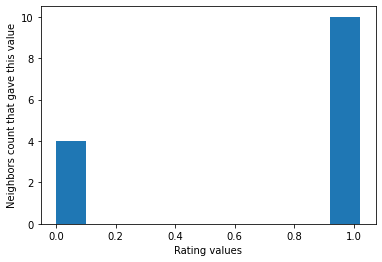

Histogram for recommeded item :  565
neighbors_rating_list :  [1.0021434829329425, 1.000714494310981, 1.0261073952996482, 1.0020300711375487, 1.0057386368469252, 1.0027332242689901, 1.0010660708767016, 1.0000453647181575, 0, 1.0000453647181575, 0, 1.0101730380468221, 0, 0]


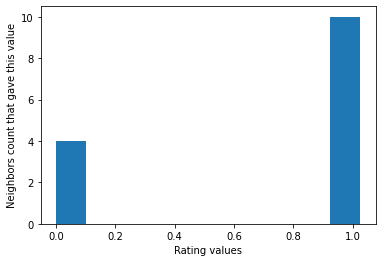

Histogram for recommeded item :  583
neighbors_rating_list :  [1.0048086601246962, 1.0013609415447253, 1.0046952483293026, 1.0017805651876823, 1.0040601422750972, 1.003300283245959, 1.0009526590813078, 1.0000793882567756, 0, 1.0000567058976968, 0, 1.0076552961890801, 0, 0]


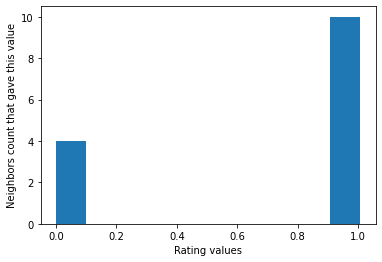

Histogram for recommeded item :  227
neighbors_rating_list :  [0, 1.0028579772439232, 1.014369274476392, 1.0018826358035366, 1.0181572284425442, 0, 0, 0, 1.01859953444458, 0, 1.014879627555664, 1.0091409907087387, 1.0122031091843706, 1.0198697465529902]


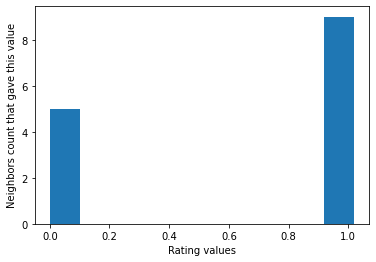

Histogram for recommeded item :  735
neighbors_rating_list :  [0, 1.000929976722229, 0, 0, 1.0036064950935222, 0, 1.0008846120040715, 0, 1.0045137894566725, 1.0000453647181575, 1.018542828546883, 1.0111483794872085, 1.0032208949891834, 1.0044797659180542]


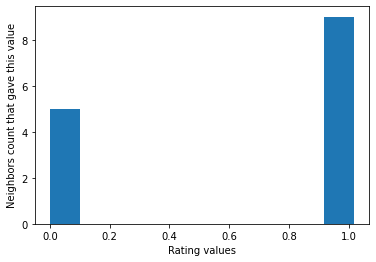

Histogram for recommeded item :  7056
neighbors_rating_list :  [1.0080295551138796, 1.0028352948848445, 1.009900849737877, 0, 1.0032549185278015, 1.0098895085583377, 1.0013382591856466, 1.0001134117953938, 0, 1.0000567058976968, 0, 1.0079048021389465, 0, 0]


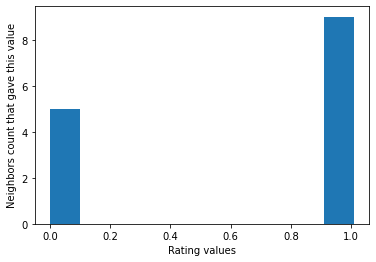

Histogram for recommeded item :  728
neighbors_rating_list :  [0, 1.0026765183712931, 1.0234535592874336, 0, 1.0038900245820066, 1.0021434829329425, 1.0010887532357804, 0, 1.0016104474945917, 1.0001474353340118, 0, 1.0084718611159154, 0, 0]


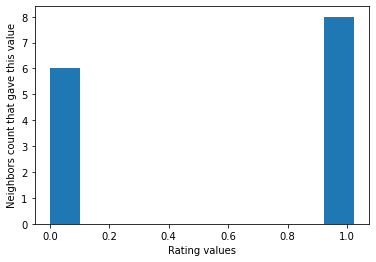

Histogram for recommeded item :  1412
neighbors_rating_list :  [0, 0, 0, 0, 1.029430360904686, 0, 1.0005330354383508, 0, 1.0033229656050378, 1.0000567058976968, 1.1446907685633845, 1.008823437681636, 0, 1.0048086601246962]


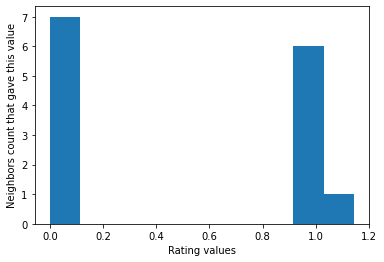

Histogram for recommeded item :  5660
neighbors_rating_list :  [0, 1.0011227767743984, 1.038945610538224, 0, 1.0027672478076082, 1.002041412317088, 1.0004423060020358, 0, 0, 1.000034023538618, 0, 0, 0, 1.0034136950413528]


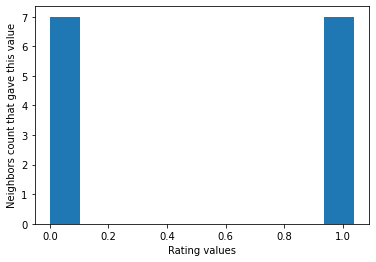

Histogram for recommeded item :  2894
neighbors_rating_list :  [1.0040714834546367, 1.0009753414403866, 1.014788898119349, 0, 0, 1.0033229656050378, 1.0016898357513673, 1.0000567058976968, 0, 1.0001020706158543, 0, 0, 0, 0]


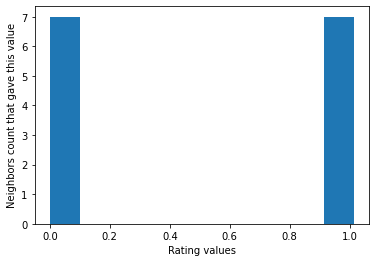




User id :  15
Histogram for recommeded item :  154
neighbors_rating_list :  [1.0397281519264412, 1.005886072180937, 1.0702359248873679, 1.0252227832955767, 1.0295324315205403, 1.0384692809975702, 1.019053181626155, 1.0058974133604766, 1.0100142615332708, 1.0017238592899855, 1.0008846120040715, 1.0223081001539565, 1.055027403125062, 1.0059200957195553]


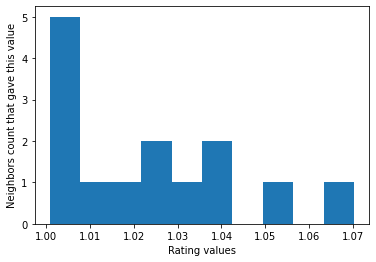

Histogram for recommeded item :  227
neighbors_rating_list :  [1.0130536976498241, 0, 1.012872238777194, 1.0057499780264647, 1.0011227767743984, 1.0119195796958862, 0, 1.0038560010433886, 1.0015537415968947, 1.001168141492556, 1.002971389039317, 1.08751988250538, 1.0080182139343403, 0]


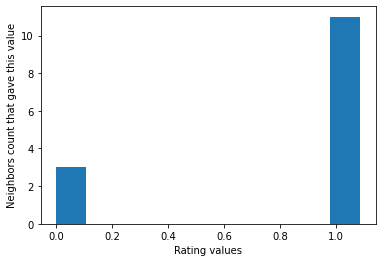

Histogram for recommeded item :  615
neighbors_rating_list :  [1.0045251306362117, 1.0309273966038839, 1.0083017434228247, 1.0070655548530325, 1.0028352948848445, 1.0451492357462637, 0, 1.003300283245959, 0, 1.0004763295406538, 0, 1.0143919568354707, 1.0039467304797036, 0]


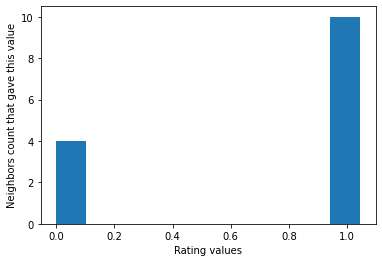

Histogram for recommeded item :  212
neighbors_rating_list :  [1.002971389039317, 1.011760803182335, 0, 1.0241000065211783, 0, 1.002427012421427, 0, 1.0037085657093765, 1.00237030652373, 0, 1.00036291774526, 0, 1.010921555896421, 0]


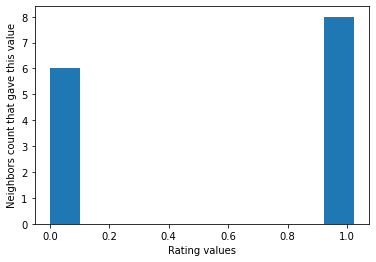

Histogram for recommeded item :  429
neighbors_rating_list :  [1.0032549185278015, 1.0111824030258267, 0, 0, 1.020187299580093, 1.0049901189973263, 0, 0, 0, 0, 0, 1.01002560271281, 1.0028012713462264, 1.006180942848961]


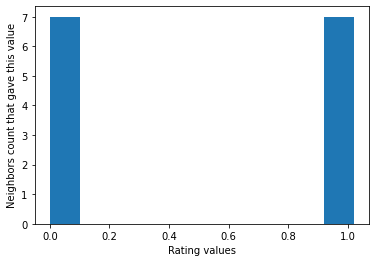

Histogram for recommeded item :  440
neighbors_rating_list :  [1.0179304048517566, 0, 1.0742053377261502, 1.0155033924303296, 1.0012815532879498, 0, 0, 1.0101843792263614, 0, 0, 0, 0, 0, 1.0061128957717247]


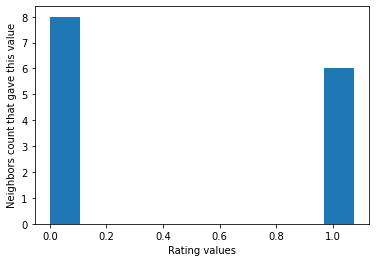

Histogram for recommeded item :  418
neighbors_rating_list :  [0, 0, 1.0307799612698718, 0, 0, 1.015299251198621, 1.0235896534419062, 1.0205842408639711, 0, 1.0007258354905202, 0, 0, 1.014970356991979, 0]


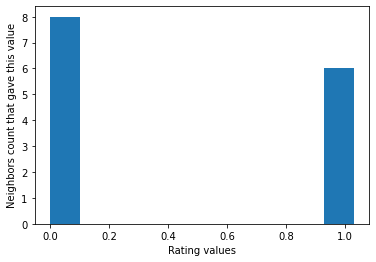

Histogram for recommeded item :  203
neighbors_rating_list :  [1.0043550129431211, 0, 1.0283983135666024, 0, 1.0164900750502557, 0, 0, 0, 1.0032435773482622, 0, 1.0005330354383508, 1.0108535088191848, 0, 0]


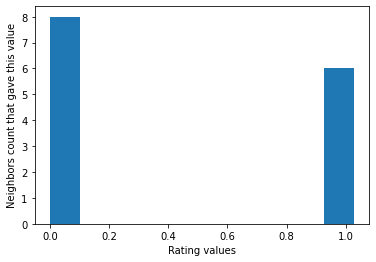

Histogram for recommeded item :  622
neighbors_rating_list :  [1.0025971301145176, 0, 1.0267992072515502, 1.0096740261470893, 1.0038673422229278, 0, 0, 1.00401477755694, 0, 0, 0, 1.0143465921173132, 0, 0]


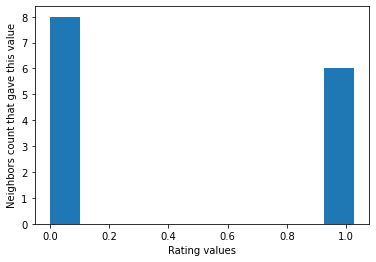

Histogram for recommeded item :  199
neighbors_rating_list :  [1.0053303543835077, 0, 1.0145734157081008, 1.0186562403422768, 0, 0, 0, 1.0102977910217552, 1.004230259968188, 0, 0, 0, 0, 1.0057046133083072]


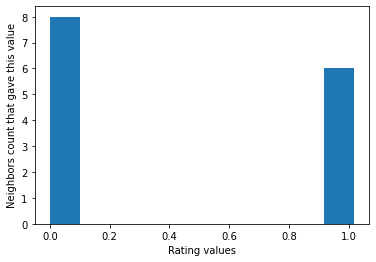




User id :  16
Histogram for recommeded item :  300
neighbors_rating_list :  [1.0189170874716824, 1.002585788934978, 1.0000453647181575, 0, 1.0541881558391482, 1.0035611303753647, 1.0042756246863456, 1.0773241620994791, 1.0013722827242648, 1.0734568198765513, 1.0148456040170457, 0, 1.085716634958619, 1.0096400026084713]


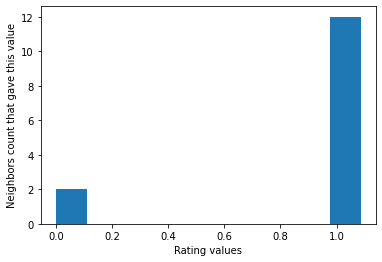

Histogram for recommeded item :  289
neighbors_rating_list :  [0, 1.0621269815167127, 1.003175530271026, 0, 1.1993892774818045, 1.0163993456139406, 1.1722044701259153, 1.0083017434228247, 1.005942778078634, 1.203869043399859, 1.2136337989832633, 0, 1.0467596832408554, 1.0062036252080397]


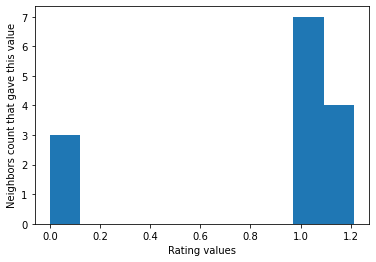

Histogram for recommeded item :  288
neighbors_rating_list :  [0, 1.0058407074627798, 1.0001360941544726, 0, 1.0073037196233594, 1.044287306101271, 1.0042075776091093, 1.0146641451444158, 1.0149023099147427, 1.2249182726249443, 1.0095039084539987, 0, 1.0646106998358364, 1.0736723022877994]


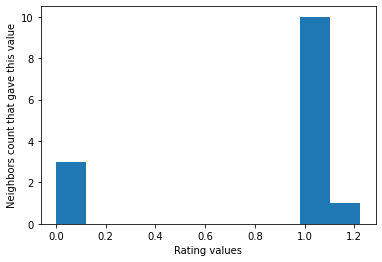

Histogram for recommeded item :  292
neighbors_rating_list :  [0, 1.011034967691815, 1.0002041412317089, 0, 1.109748594402561, 0, 1.0057953427446222, 1.0055685191538346, 1.0129289446748908, 0, 1.02661774837892, 1.1560432892823018, 1.022739064976453, 1.0058293662832403]


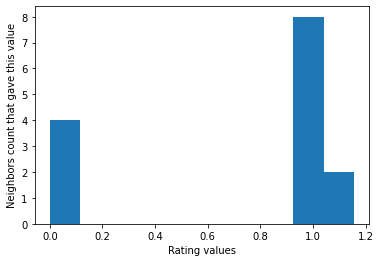

Histogram for recommeded item :  701
neighbors_rating_list :  [1.0054777897175196, 1.0099802379946525, 1.000510353079272, 1.041372622959651, 1.0122257915434494, 0, 1.019983158348384, 0, 1.001678494571828, 1.0516817551609454, 1.0954473670034053, 0, 0, 1.0132691800610722]


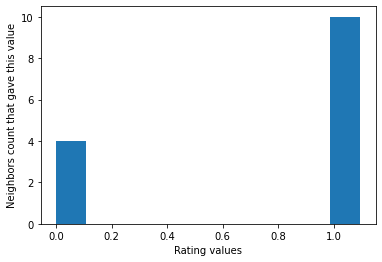

Histogram for recommeded item :  386
neighbors_rating_list :  [1.0144486627331675, 1.001950682880773, 1.0001020706158543, 1.0191552522420095, 1.003425036220892, 1.0204821702481166, 0, 1.0130536976498241, 1.0129516270339696, 1.006782025364548, 0, 0, 1.0176355341837329, 0]


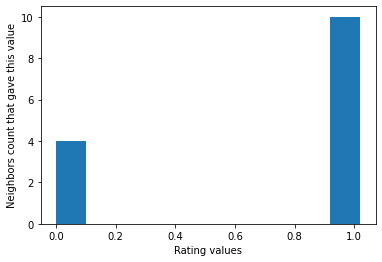

Histogram for recommeded item :  466
neighbors_rating_list :  [0, 1.0043663541226606, 1.0001134117953938, 0, 1.0117834855414136, 1.00911830834966, 0, 1.0118175090800319, 1.0126454151864064, 1.0141424508856043, 1.0056138838719921, 0, 1.02315868861941, 1.0034704009390496]


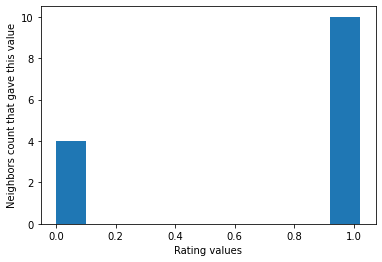

Histogram for recommeded item :  295
neighbors_rating_list :  [0, 1.0043323305840424, 1.00036291774526, 0, 0, 1.0097420732243256, 1.0068047077236268, 1.003062118475632, 1.002041412317088, 1.034806080006351, 1.004468424738515, 0, 1.025381559809128, 1.0019620240603124]


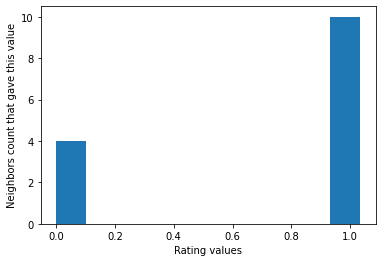

Histogram for recommeded item :  333
neighbors_rating_list :  [0, 1.0029827302188563, 1.0006464472337446, 0, 1.014255862680998, 0, 0, 1.0050241425359445, 1.0013042356470285, 1.0075418843936863, 1.0706668897098643, 0, 1.0284777018233782, 1.0017352004695248]


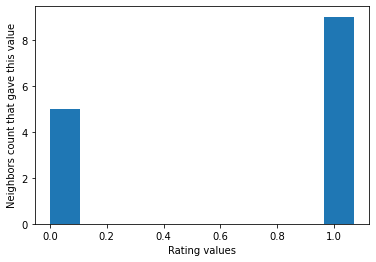

Histogram for recommeded item :  461
neighbors_rating_list :  [0, 1.0055344956152164, 1.0000567058976968, 1.012872238777194, 0, 1.0071789666484263, 1.0046385424316056, 1.0277632075123972, 1.0030394361165533, 0, 0, 0, 1.047825754117557, 1.0217183588179088]


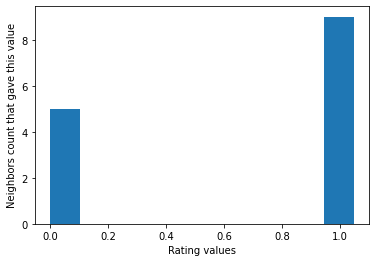

In [75]:
#picking a user and its 1 recommeded item for histogram
#NOTE this histogram plot can be done for any of the 5 test users and their recommeded items

for i in range (0,len(ids_test_users)):
  u=ids_test_users[i];
  print("User id : ", u)

  recommeded_item_ids = recommendations[i];

  user_neighbors = neighbors[i];


  for r in recommeded_item_ids:

    print("Histogram for recommeded item : ", r)

    neighbors_rating_list=[];

    for nu in user_neighbors:
      df=ratings[(ratings['artistID']==r) & (ratings['userID']==nu)]
      #print("neigh : ", nu)
      #print(df)

      if df.shape[0] > 0:
        neighbor_rating=df['rating'].values[0];
 
        #print("neighbor_rating : ", neighbor_rating)

        neighbors_rating_list.append(neighbor_rating)
      else:
         neighbors_rating_list.append(0)



    print("neighbors_rating_list : ",neighbors_rating_list)




    plt.figure()
    #plt.yscale("log")
    plt.hist(neighbors_rating_list)
    #plt.bar(user_neighbors,neighbors_rating_list)
    plt.xlabel('Rating values')
    plt.ylabel('Neighbors count that gave this value')
    plt.show()



  print("\n\n========================================================\n")
    
    










**Ques : Also, find out that can we explain such recommendations using items? If yes, then how? If no, then why not?
**

Yes, we can give similar recommedations using items. 
Consider the scenario of items bought together in online shopping platforms.

We can find neighbours of the items bought/ highest rated by the user. Then we can find neighbours of that items, and recommeded the closest item neighbours to user. For explanations, we can give the histogram to ratings received by the item specific to user.


#Question 3

Use the Naive Bayes (or Logistic Regression) model for generating content-based
recommendation. For any five users, by using tag-preference and tag-relevance
formulation, generate top-3 tags (i.e. features) that can be shown to the user as an  explanation (Useful resources: [Tagsplanation by Vig et al.]). Also, can you define your own formulations for ranking tags (based on their affinity with the item to which they are assigned and the user who have assigned them)?

In [82]:
user_taggedartists #, len(user_taggedartists['userID'].unique()) , len(user_taggedartists['artistID'].unique())

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


Extracting ratings for this question only those user-artist ratings where tag is available

In [89]:
ratings_for_tagging = user_artists[user_artists['artistID'].isin(user_taggedartists['artistID'].unique())]
print(ratings_for_tagging)

distinct_artists_ids = ratings_for_tagging['artistID'].unique()
print(distinct_artists_ids)
print(len(distinct_artists_ids))

distinct_tags_ids = user_taggedartists['tagID'].unique()
print(len(distinct_tags_ids))
print(distinct_tags_ids)

       userID  artistID  weight   ratings
0           2        51   13883  1.157438
1           2        52   11690  1.132567
2           2        53   11351  1.128722
3           2        54   10300  1.116803
4           2        55    8983  1.101866
...       ...       ...     ...       ...
92820    2100      8533     724  1.008200
92821    2100      9783     793  1.008982
92823    2100     10894     705  1.007984
92826    2100     13978     535  1.006056
92827    2100     16437     443  1.005013

[86608 rows x 4 columns]
[   51    52    53 ... 18724 10894 13978]
12133
9749
[   13    15    18 ... 12644  6027 12645]


In [101]:
T= len(distinct_tags_ids);
A= len(distinct_artists_ids);
artist_tag_matrix = np.array(np.zeros((A,T), dtype = np.float))
#print(artist_tag_matrix.shape)

artist_tag_matrix = pd.DataFrame(artist_tag_matrix, index = distinct_artists_ids, columns = distinct_tags_ids)
print(artist_tag_matrix.shape)
#artist_tag_matrix

for A in distinct_artists_ids:
    artists_tags_q3 = user_taggedartists[user_taggedartists['artistID'] == A]['tagID'].values
    for T in artists_tags_q3:
        artist_tag_matrix.loc[A,T] = artist_tag_matrix.loc[A,T] + 1

artist_tag_matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


(12133, 9749)


,13,15,18,21,41,14,23,40,20,22,...,12638,12640,12641,12642,12647,12646,12643,12644,6027,12645
51,1.0,0.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,10.0,7.0,6.0,15.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53,16.0,7.0,31.0,9.0,0.0,16.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,8.0,4.0,8.0,16.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
55,1.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18722,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18724,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
our_user_ids_for_tags = ratings_for_tagging['userID'].unique()
our_user_ids_for_tags,our_user_ids_for_tags.shape

(array([   2,    3,    4, ..., 2097, 2099, 2100]), (1892,))

In [108]:
dummy_user_dict = dict()
for u in our_user_ids_for_tags:
    final_list = np.array([0]*len(distinct_tags_ids))
    
    dummy_ratings = ratings_for_tagging[ratings_for_tagging['userID'] == u]
    
    all_artists = dummy_ratings[dummy_ratings['ratings'] >= 1.003000]['artistID'].values
    for a in all_artists:
        final_list = final_list+artist_tag_matrix.loc[a]
    dummy_user_dict[u] = final_list

P_u = pd.DataFrame(dummy_user_dict)
P_u = P_u.T
P_u

,13,15,18,21,41,14,23,40,20,22,...,12638,12640,12641,12642,12647,12646,12643,12644,6027,12645
2,175.0,51.0,523.0,138.0,1.0,104.0,22.0,1.0,23.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2.0,8.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,87.0,16.0,247.0,24.0,0.0,96.0,10.0,0.0,5.0,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
5,14.0,0.0,39.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2096,33.0,1.0,135.0,28.0,0.0,12.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,15.0,1.0,0.0,0.0,1.0,0.0,0.0
2097,16.0,0.0,120.0,2.0,0.0,8.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2099,33.0,40.0,39.0,39.0,0.0,11.0,0.0,0.0,7.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
artist_tag_matrix.shape

(12133, 9749)

Our 5 test users

In [107]:
ids_test_users

Int64Index([12, 13, 14, 15, 16], dtype='int64', name='userID')

In [110]:
similarity_matrix_tags = list()
for u in ids_test_users:
    similarity_matrix_tags.append( P_u.loc[u] @ artist_tag_matrix.T)

print(len(similarity_matrix_tags))
print(len(similarity_matrix_tags[0]))
similarity_matrix_tags = pd.DataFrame(similarity_matrix_tags, columns = artist_tag_matrix.index, index = ids_test_users)
similarity_matrix_tags

5
12133


,51,52,53,54,55,56,57,58,59,60,...,18715,18716,18717,18719,18721,18722,18723,18724,10894,13978
userID,,,,,,,,,,,,,,,,,,,,,
12,20552.0,2726.0,8429.0,5380.0,35386.0,11410.0,896.0,16470.0,18863.0,0.0,...,37.0,545.0,14.0,0.0,1.0,157.0,0.0,14.0,0.0,1.0
13,2432.0,683.0,1767.0,873.0,11649.0,4137.0,261.0,3877.0,1935.0,0.0,...,0.0,5.0,0.0,0.0,0.0,53.0,0.0,0.0,1.0,0.0
14,1337.0,53.0,259.0,114.0,979.0,186.0,15.0,380.0,825.0,0.0,...,2.0,51.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15,18869.0,1191.0,7217.0,2899.0,12108.0,6033.0,868.0,8483.0,18487.0,3.0,...,113.0,368.0,39.0,0.0,11.0,113.0,5.0,44.0,0.0,1.0
16,3250.0,841.0,2001.0,1079.0,15226.0,5045.0,292.0,4776.0,2320.0,0.0,...,0.0,9.0,0.0,0.0,0.0,58.0,0.0,0.0,1.0,0.0


In [113]:
neighbors_tags = []
for u in ids_test_users:
    new = similarity_matrix_tags.loc[u].sort_values(ascending=False)[0:25]
    neighbors_tags.append(new.index)
print(neighbors_tags)

##-------------------------
artist_related_to_user = []

for u in ids_test_users:
    artist_related_to_user.append( ratings_for_tagging[ratings_for_tagging['userID'] == u]['artistID'].values)
    
print(artist_related_to_user)

#--------------------------
recommeded_items_tags = []

for i in range(len(ids_test_users)):
    user = ids_test_users[i] 
    list_of_recommendations = [item for item in neighbors_tags[i] if item not in artist_related_to_user[i]][0:10]
    recommeded_items_tags.append(list_of_recommendations)
    print("User : ", u)
    print("list_of_recommendations : ", list_of_recommendations)

[Int64Index([ 190,  498,  154,  289,   89,  333,   65,  377,   67,  227,  292,
             173,  300,  229,  486,  288,  234,  220, 1098,  511,  378,   72,
             533,  230,  291],
           dtype='int64'), Int64Index([  89,  289,   67,  292,  288,   55,  300,  157,  333,  466,  349,
             461,  291,  295,  701,  525,  318, 1098,  298,   72,  306,  299,
             302,  310,  257],
           dtype='int64'), Int64Index([ 227, 1412,  735,  959,  868,  163,  903, 1249,  562,  599,  706,
            1639,  511,  190, 2786,  292,  157,  733, 1372,  728, 1244, 1415,
             220,  301,  154],
           dtype='int64'), Int64Index([ 190,  227,  154,   65,  173,  229,  498,  533,   72,  599,  511,
             959,  234, 1090,  207,  486,  377,  159,  220,  182, 1412,  424,
            1098,  163,  735],
           dtype='int64'), Int64Index([  89,  289,   67,  292,  288,   55,  300,  157,  333,  466,  349,
             461,  701,  291,  295,  525,  318,  299,  298,  306,

#####TAG PREFERENCE

In [116]:
tags_ques_3 = P_u.columns.values
#tags_ques_3

Tag_Preference = []

for u in ids_test_users:
    user_artist_ratings_list = user_item_ratings_matrix.loc[u][list(artist_tag_matrix.index.values)]
    average_user_rating = ratings_for_tagging[ratings_for_tagging['userID'] == u]['ratings'].mean()
    k = 0.05**7;
    T_P_V = []
    for TAG in tags_ques_3:
        tag_share_vec = artist_tag_matrix[TAG]/sum(artist_tag_matrix[TAG])
        U_T_P = (np.dot(user_artist_ratings_list, tag_share_vec) + (average_user_rating * k)) / (np.sum(tag_share_vec) + k)
        T_P_V.append(U_T_P)
    Tag_Preference.append(T_P_V)


Tag_Preference = pd.DataFrame(Tag_Preference, index = ids_test_users, columns = artist_tag_matrix.columns.values)
Tag_Preference

,13,15,18,21,41,14,23,40,20,22,...,12638,12640,12641,12642,12647,12646,12643,12644,6027,12645
userID,,,,,,,,,,,,,,,,,,,,,
12,9.934192e-03,1.482108e-03,3.199099e-02,3.489413e-03,8.266314e-10,9.827447e-03,4.321959e-03,8.266314e-10,8.266314e-10,8.266314e-10,...,8.266314e-10,8.266314e-10,8.266314e-10,8.266314e-10,1.690804e-01,8.266314e-10,8.266314e-10,1.697760e-01,8.266314e-10,8.266314e-10
13,1.600123e-02,7.819874e-10,6.094134e-02,3.428870e-03,7.819874e-10,6.024173e-04,7.819874e-10,7.819874e-10,3.937053e-03,7.819874e-10,...,7.819874e-10,7.819874e-10,7.819874e-10,5.128380e-02,7.819874e-10,7.819874e-10,7.819874e-10,7.819874e-10,7.819874e-10,7.819874e-10
14,7.322966e-04,7.873940e-10,7.873940e-10,7.873940e-10,7.873940e-10,6.065711e-04,7.873940e-10,7.873940e-10,7.873940e-10,7.873940e-10,...,7.873940e-10,7.873940e-10,7.873940e-10,7.873940e-10,7.873940e-10,7.873940e-10,7.873940e-10,7.873940e-10,7.873940e-10,7.873940e-10
15,3.069428e-02,1.914237e-02,1.875819e-02,9.185812e-03,7.848328e-10,3.691780e-02,7.848328e-10,7.848328e-10,1.581389e-02,2.419791e-02,...,7.848328e-10,7.848328e-10,7.848328e-10,1.029776e-01,1.680635e-01,7.848328e-10,7.848328e-10,7.848328e-10,7.848328e-10,7.848328e-10
16,7.838842e-10,7.838842e-10,1.593414e-02,1.146098e-03,7.838842e-10,7.838842e-10,7.838842e-10,7.838842e-10,7.838842e-10,7.838842e-10,...,7.838842e-10,7.838842e-10,7.838842e-10,7.838842e-10,7.838842e-10,7.838842e-10,7.838842e-10,7.838842e-10,7.838842e-10,7.838842e-10


In [117]:
Top_Tag_per_user = []
for u in ids_test_users:
    TT = Tag_Preference.loc[u].sort_values(ascending = False)[0:3].index.values
    print('Top 3 tags for user  ', u ,' as per tag preference: ', TT)
    Top_Tag_per_user.append(TT)

Top 3 tags for user   12  as per tag preference:  [9484 4028 2980]
Top 3 tags for user   13  as per tag preference:  [ 5518 11228  4977]
Top 3 tags for user   14  as per tag preference:  [ 5937 10267  7466]
Top 3 tags for user   15  as per tag preference:  [1699 9026 4226]
Top 3 tags for user   16  as per tag preference:  [11923  9868  5658]


#####TAG RELEVANCE

In [120]:
recommeded_item_for_tag_relevance_test_user = recommeded_items_tags[0]
print(recommeded_item_for_tag_relevance_test_user)

top_tag_list_for_tag_relevance_test_user = Top_Tag_per_user[0]
print(top_tag_list_for_tag_relevance_test_user)

active_batch_item = recommeded_item_for_tag_relevance_test_user[0]
active_batch_user = ids_test_users[0]
active_batch_tag = top_tag_list_for_tag_relevance_test_user[0]

print("active_batch_item : ", active_batch_item)
print("active_batch_user :",active_batch_user )
print("active_batch_tag : ",active_batch_tag )


[190, 154, 289, 89, 65, 67, 227, 292, 173, 229]
[9484 4028 2980]
active_batch_item :  190
active_batch_user : 12
active_batch_tag :  9484


In [121]:
relevance_X = user_item_ratings_matrix[active_batch_item] - user_item_ratings_matrix.mean(axis = 1)
relevance_X

userID
2      -0.002944
3      -0.002849
4       0.999495
5       1.006512
6      -0.002836
          ...   
2095   -0.002839
2096    1.037998
2097   -0.002845
2099   -0.002842
2100   -0.002856
Length: 1892, dtype: float64

In [125]:
Tag_Preference_for_Relevance = []
k = 0.05**7
for u in P_u.index.values:
    user_artist_ratings_list = user_item_ratings_matrix.loc[u][list(artist_tag_matrix.index.values)]
    average_user_rating = ratings_for_tagging[ratings_for_tagging['userID'] == u]['ratings'].mean()
    tag_share_list = artist_tag_matrix[active_batch_tag]/sum(artist_tag_matrix[active_batch_tag])
    U_T_P = (np.dot(user_artist_ratings_list, tag_share_list) + (average_user_rating * k)) / (np.sum(tag_share_list) + k)
    Tag_Preference_for_Relevance.append(U_T_P)

print(Tag_Preference_for_Relevance) 
#-------------------
relevance_Y = np.array(Tag_Preference_for_Relevance)- user_item_ratings_matrix.mean(axis = 1)
print(relevance_Y)

[8.111423361312809e-10, 7.87191850540313e-10, 7.861158103082354e-10, 7.835947231615273e-10, 7.814230842516698e-10, 8.055735023508594e-10, 7.876302183570657e-10, 1.0068954371589607, 7.863667302119553e-10, 7.890367233042867e-10, 1.677000370940105, 7.819873532650619e-10, 7.873939821397752e-10, 7.848327639670674e-10, 7.838841655415414e-10, 7.875550233027981e-10, 7.849141011748177e-10, 7.829068748366852e-10, 7.854662347709162e-10, 7.927053996990658e-10, 7.842013822387735e-10, 7.920230567080596e-10, 7.853930017079398e-10, 7.868259536475219e-10, 7.822676677314496e-10, 7.813302958267547e-10, 7.825395269434547e-10, 7.842818481968583e-10, 7.864969915750357e-10, 1.0019053181670672, 7.886721001093297e-10, 7.881156442492506e-10, 7.812537966595808e-10, 7.862808395825389e-10, 7.839677990359736e-10, 7.83431440554447e-10, 7.819275905651147e-10, 7.850002084897168e-10, 7.897547765004733e-10, 1.001893976985531, 1.0116473913828876, 7.841007111882023e-10, 7.896487900188725e-10, 7.949981055899803e-10, 7.9023

In [130]:
## Tag rel is defined using Pearson correlation

import scipy.stats
Correlation , p_val = scipy.stats.pearsonr(relevance_X, relevance_Y)
Tag_Relevance = Correlation;
print("For given active-test (tag -  item ) set TAG RELEVANCE =",Tag_Relevance )

For given active-test (tag -  item ) set TAG RELEVANCE = 0.18820617188004998


**Also, can you define your own formulations for ranking tags (based on their affinity with the item to which they are assigned and the user who have  assigned them) ?**

Formulation for ranking tags:

T : Tag

T_T_A_U : total tags assignedd by user U

N_u_a_T  : no. of times user assigned tag T

t_r_vec : tag representation vector for tag T (generated by BERT models)

i_f_r_vec : item feature representation vector for item I (generated by BERT models)

sim_I_T  : (cosine)  similarity between a single tag representation vector (t_r_vec) and an item feature representation vector (i_f_r_vec)

alpha : Parameter trained using exhaustive search methods for best accuracy


**Tag_Rank_score_T_I = alpha * ( (summation over all user [ N_u_a_T / T_T_A_U])/ total_no_of_usrs  ) + (1 -alpha) * (sim_I_T)**

Tag_Rank = normalized ( Tag_Rank_score_T )   
NOTE : Tag Rank is normalized over all tags


# **CONVERSATIONAL RECOMMENDATION** 




#Question 4

For a user,

a. Choose an item from her test-set, we call it target.

b. Find the top-5 neighbours of the target.

c. Consider the 5th neighbor (the farthest one) as a seed (i.e. a start point),
recommend top-3 items to the user using k-NN based recommendation algorithm.

d. Now, out of the 3 recommendations, select the one which is closest to the 1st
neighbor (the nearest one), and treat it as a seed for the next round of
recommendations.

e. Repeat the steps c and d for 5 rounds of recommendations or until you find the target as one of the top-3 recommendations in a round, whichever comes
earlier.

Repeat steps a–to–e for 100 users and find out the overall hit-rate. Also, show the hit-rate histograms over the 5 rounds of recommendations


In [24]:
ratings

,userID,artistID,rating
0,2,51,1.157438
1,2,52,1.132567
2,2,53,1.128722
3,2,54,1.116803
4,2,55,1.101866
...,...,...,...
92829,2100,18726,1.003811
92830,2100,18727,1.003357
92831,2100,18728,1.003176
92832,2100,18729,1.003164


In [25]:
N=100;


Selecting 100 users who have given most no. of tags

In [26]:
tagged_cnt= pd.DataFrame(user_taggedartists.groupby('userID')['artistID'].count(), columns=["artistID"] ).rename(columns={'artistID':'artist_tagged_count'})


In [27]:
tagged_cnt_new=tagged_cnt.sort_values('artist_tagged_count', ascending=False )[250:300+N]
print(tagged_cnt_new)

user_ids=tagged_cnt_new.index.to_list()
print(user_ids)



        artist_tagged_count
userID                     
1584                    198
1938                    198
1854                    197
2071                    196
898                     196
...                     ...
813                      95
1771                     95
1617                     95
843                      95
1951                     95

[150 rows x 1 columns]
[1584, 1938, 1854, 2071, 898, 1004, 2099, 582, 240, 1253, 950, 1233, 1349, 16, 1461, 1335, 862, 78, 972, 1941, 1355, 2014, 1622, 283, 1309, 1795, 2069, 1604, 1497, 249, 1895, 1889, 2053, 1605, 905, 1760, 1104, 436, 238, 39, 177, 698, 1465, 1774, 1128, 1100, 1690, 847, 1629, 658, 720, 981, 1904, 567, 686, 143, 205, 380, 1088, 580, 1426, 2077, 1020, 248, 1800, 1635, 2007, 643, 578, 431, 1573, 1875, 9, 751, 490, 372, 771, 1049, 1073, 87, 111, 595, 1845, 252, 1743, 1352, 1669, 2066, 1350, 1112, 1734, 1074, 273, 563, 1091, 765, 2036, 1052, 378, 1437, 340, 912, 1920, 1543, 1689, 84, 943, 1161, 683, 941, 1492, 4

Getting artist IDs associated with these 100 users

In [28]:
shortened_user_taggedartists=user_taggedartists[user_taggedartists["userID"].isin(user_ids)]
print(shortened_user_taggedartists)

        userID  artistID  tagID  day  month  year
242          9         8     73    1      6  2008
243          9         8    138    1      6  2008
244          9         8    139    1      6  2008
245          9         8    141    1      6  2008
246          9       209     73    1     11  2007
...        ...       ...    ...  ...    ...   ...
186459    2099     18723    626    1     11  2010
186460    2099     18723   2485    1     11  2010
186461    2099     18724     13    1      2  2010
186462    2099     18724     15    1      2  2010
186463    2099     18724   2525    1      2  2010

[20272 rows x 6 columns]


In [29]:

artist_ids = np.unique(shortened_user_taggedartists["artistID"])
print(len(artist_ids))

4337


Gettings tags associated with above artist ids for one hot encoding

In [30]:
tag_ids = np.unique(shortened_user_taggedartists["tagID"])
print(len(tag_ids))

2089


In [31]:
y1 = pd.get_dummies(shortened_user_taggedartists.tagID)
print(y1)

label_columns=y1.columns
for f in label_columns:
  shortened_user_taggedartists[f] = 0.0

shortened_user_taggedartists[label_columns] = y1

shortened_user_taggedartists['num_labels'] = shortened_user_taggedartists[label_columns].sum(axis=1)

shortened_user_taggedartists.head()

shortened_user_taggedartists

        1      2      3      4      5      6      7      9      13     14     \
242         0      0      0      0      0      0      0      0      0      0   
243         0      0      0      0      0      0      0      0      0      0   
244         0      0      0      0      0      0      0      0      0      0   
245         0      0      0      0      0      0      0      0      0      0   
246         0      0      0      0      0      0      0      0      0      0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
186459      0      0      0      0      0      0      0      0      0      0   
186460      0      0      0      0      0      0      0      0      0      0   
186461      0      0      0      0      0      0      0      0      1      0   
186462      0      0      0      0      0      0      0      0      0      0   
186463      0      0      0      0      0      0      0      0      0      0   

        ...  12547  12548  12549  12550

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

,userID,artistID,tagID,day,month,year,1,2,3,4,...,12548,12549,12550,12551,12552,12553,12563,12564,12566,num_labels
242,9,8,73,1,6,2008,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
243,9,8,138,1,6,2008,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
244,9,8,139,1,6,2008,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
245,9,8,141,1,6,2008,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
246,9,209,73,1,11,2007,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186459,2099,18723,626,1,11,2010,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
186460,2099,18723,2485,1,11,2010,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
186461,2099,18724,13,1,2,2010,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
186462,2099,18724,15,1,2,2010,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
shortened_user_taggedartists.drop(['day', 'month','year','num_labels'], axis=1,inplace=True)



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
shortened_user_taggedartists

,userID,artistID,tagID,1,2,3,4,5,6,7,...,12547,12548,12549,12550,12551,12552,12553,12563,12564,12566
242,9,8,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,9,8,138,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,9,8,139,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245,9,8,141,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,9,209,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186459,2099,18723,626,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
186460,2099,18723,2485,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
186461,2099,18724,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
186462,2099,18724,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
modified_artist_ids=[]

tags_matrix = [];

for a in artist_ids:
  

  df=shortened_user_taggedartists[shortened_user_taggedartists["artistID"] == a]

  row_cnt=df.shape[0]

  if(row_cnt> 15):

    #print("Artist ID : ", a)

    #print("row_cnt : ", row_cnt)

    modified_artist_ids.append(a)

    #print(df[label_columns])
    
    LL=df[label_columns].sum(axis=0).to_list()
    LL=np.array(LL).astype(bool).astype(int)

    tags_matrix.append(LL)

  

In [35]:
np.where(LL == 1),np.where(LL == 0), len(np.where(LL == 1)[0]),len(np.where(LL == 0)[0])

((array([  46,   51,   53,  105,  112,  113,  153,  155,  161,  162,  217,
          260,  531,  613,  804,  939, 1055, 1208, 1230, 1231, 1492, 1501,
         1890, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912,
         1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1924,
         1925, 1926, 1927, 1928]),),
 (array([   0,    1,    2, ..., 2086, 2087, 2088]),),
 48,
 2041)

In [36]:
len(modified_artist_ids),len(tags_matrix),len(tags_matrix[0])

(198, 198, 2089)

In [37]:
tags_matrix[0]

array([1, 1, 0, ..., 0, 0, 0])

In [38]:
shortened_user_taggedartists

,userID,artistID,tagID,1,2,3,4,5,6,7,...,12547,12548,12549,12550,12551,12552,12553,12563,12564,12566
242,9,8,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,9,8,138,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244,9,8,139,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
245,9,8,141,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246,9,209,73,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186459,2099,18723,626,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
186460,2099,18723,2485,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
186461,2099,18724,13,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
186462,2099,18724,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
new_shortened_user_taggedartists=shortened_user_taggedartists[shortened_user_taggedartists["artistID"].isin(modified_artist_ids)]

print(new_shortened_user_taggedartists)

modified_user_ids = np.unique(new_shortened_user_taggedartists["userID"].to_list())
print(modified_user_ids)
print(len(modified_user_ids))

        userID  artistID  tagID  1  2  3  4  5  6  7  ...  12547  12548  \
246          9       209     73  0  0  0  0  0  0  0  ...      0      0   
248          9       229     73  0  0  0  0  0  0  0  ...      0      0   
262          9       377     73  0  0  0  0  0  0  0  ...      0      0   
263          9       377    137  0  0  0  0  0  0  0  ...      0      0   
282          9       403     73  0  0  0  0  0  0  0  ...      0      0   
...        ...       ...    ... .. .. .. .. .. .. ..  ...    ...    ...   
185217    2077      1810     72  0  0  0  0  0  0  0  ...      0      0   
185218    2077      1810    415  0  0  0  0  0  0  0  ...      0      0   
185221    2077      2346  12564  0  0  0  0  0  0  0  ...      0      0   
185222    2077      2347     72  0  0  0  0  0  0  0  ...      0      0   
185223    2077      2347    761  0  0  0  0  0  0  0  ...      0      0   

        12549  12550  12551  12552  12553  12563  12564  12566  
246         0      0      0      0

In [40]:
print(modified_artist_ids)
print(modified_user_ids[0])


[7, 51, 53, 55, 56, 58, 59, 63, 65, 67, 70, 72, 81, 89, 97, 154, 157, 163, 172, 173, 190, 198, 199, 209, 212, 217, 220, 227, 228, 229, 230, 233, 234, 257, 267, 271, 285, 288, 289, 291, 292, 293, 294, 295, 298, 299, 300, 302, 306, 310, 316, 318, 320, 321, 329, 331, 333, 340, 344, 349, 377, 378, 386, 403, 412, 418, 424, 429, 430, 441, 461, 462, 464, 465, 466, 468, 470, 475, 481, 486, 488, 498, 518, 525, 526, 528, 532, 533, 534, 535, 536, 538, 540, 546, 562, 599, 603, 610, 614, 622, 630, 680, 683, 686, 687, 691, 693, 701, 704, 706, 707, 712, 718, 724, 730, 732, 735, 768, 792, 854, 863, 868, 889, 903, 907, 917, 923, 930, 936, 951, 959, 961, 964, 966, 969, 980, 982, 1001, 1034, 1043, 1044, 1045, 1047, 1048, 1090, 1098, 1104, 1114, 1180, 1198, 1244, 1246, 1249, 1250, 1339, 1358, 1375, 1394, 1400, 1401, 1412, 1464, 1527, 1673, 1700, 1713, 1803, 1810, 2343, 2346, 2347, 2523, 2661, 2787, 3200, 3317, 4118, 4384, 4565, 4625, 4627, 4704, 4707, 5027, 5423, 5547, 5746, 5778, 6836, 9900, 11740, 13947

In [41]:
from numpy import dot
from numpy.linalg import norm

def CosineSimilarity(a,b):
  cos_sim = dot(a, b)/(norm(a)*norm(b))
  return cos_sim

In [42]:
SimMat = np.array(np.zeros((len(modified_artist_ids),len(modified_artist_ids)), dtype = np.float))
SimMat,SimMat.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), (198, 198))

In [43]:
for i in range(0,len(modified_artist_ids)):
  a=tags_matrix[i];
  for j in range(0,len(modified_artist_ids)):
    b=tags_matrix[j];

    SimMat[i][j]=CosineSimilarity(a,b);


In [44]:
SimMat

array([[1.        , 0.        , 0.07692308, ..., 0.06726728, 0.13074409,
        0.08006408],
       [0.        , 1.        , 0.        , ..., 0.        , 0.04303315,
        0.        ],
       [0.07692308, 0.        , 1.        , ..., 0.        , 0.06537205,
        0.08006408],
       ...,
       [0.06726728, 0.        , 0.        , ..., 1.        , 0.0571662 ,
        0.035007  ],
       [0.13074409, 0.04303315, 0.06537205, ..., 0.0571662 , 1.        ,
        0.06804138],
       [0.08006408, 0.        , 0.08006408, ..., 0.035007  , 0.06804138,
        1.        ]])

In [45]:
def getNeighbors(idx):
  global SimMat

  row_sim_mat = SimMat[idx];

  #print(row_sim_mat)

  indexes = list(range(0,len(row_sim_mat)))

  #print(indexes)

  #Sorting indexes based on similarity scores
  neighbors_indexes = [x for _, x in sorted(zip(row_sim_mat,indexes ), key=lambda pair: pair[0], reverse=True )]

  return neighbors_indexes[1:]


def get_K_Neighbors(K,idx):
  
  neighbors_indexes = getNeighbors(idx) ;

  #print(neighbors_indexes)


  #In neighbors_indexes first position or at 0th index will be artist herself with similarity score of 1
  #so we will return K neighbors starting from index 1



  return neighbors_indexes[1:1+K]





In [67]:
from collections import defaultdict

#the overall hit-rate. 
#--> for this we will cnt - for how many users system landed with target;
target_hit_cnt_overall = 0;



#Also, show the hit-rate histograms over the 5 rounds of recommendations

hit_rate_hist=defaultdict(int);

total_ROUNDS = 5; 

for i in range (1,total_ROUNDS+1 ):
  hit_rate_hist[i]=0;





total_usrs_cnt = 100;
for u in modified_user_ids[0:total_usrs_cnt]:
  print("User ID : ", u)

  XX = new_shortened_user_taggedartists[new_shortened_user_taggedartists["userID"]==u]
  print(XX)

  ##----------------------------------------------------------------------------------------
  #a. Choose an item from her test-set, we call it target.

  target=XX.iloc[0]["artistID"]
  print("target (artistID): ", target)

  #finding index of target in modified_artist_ids

  target_idx=np.where(modified_artist_ids == target)[0][0]

  print("target_idx :  ", target_idx)
  ##----------------------------------------------------------------------------------------
  #b. Find the top-5 neighbours of the target.

  neighbours_at_step_b_indexes = get_K_Neighbors(5,23)

  print("neighbours_at_step_b_indexes : ", neighbours_at_step_b_indexes)

  neighbours_at_step_b=list(map(modified_artist_ids.__getitem__, neighbours_at_step_b_indexes));

  print("neighbours_at_step_b : ", neighbours_at_step_b)

  ##----------------------------------------------------------------------------------------                      
  ## c. KNN 
  ##Consider the 5th neighbor (the farthest one) as a seed (i.e. a start point),
  ##recommend top-3 items to the user using k-NN based recommendation algorithm.

  #Setting seed for firt round of 5 ROUNDS
  seed= modified_artist_ids[neighbours_at_step_b_indexes[-1]]

  ROUND_CNT = 1;

  while ROUND_CNT <=total_ROUNDS:
    print("--------------------------------------------------------------------")
    print("ROUND_CNT : ",ROUND_CNT );
    ROUND_CNT=ROUND_CNT+1;


    print("seed : ", seed)

    #finding index of seed in modified_artist_ids

    seed_idx=np.where(modified_artist_ids == seed)[0][0]

    print("seed_idx :  ",seed_idx)
    seed_neighbor_indexes = getNeighbors(seed_idx)

    print("seed_neighbor_indexes : " , seed_neighbor_indexes)
    print("len - seed_neighbor_indexes : " , len(seed_neighbor_indexes))


    crunched_candidate_set_indexes=[];

    for s in seed_neighbor_indexes:
      if s not in neighbours_at_step_b_indexes:
        crunched_candidate_set_indexes.append(s)

    print("crunched_candidate_set_indexes : ", crunched_candidate_set_indexes)
    print("len(crunched_candidate_set_indexes) = ",len(crunched_candidate_set_indexes) )

    reduced_crunched_candidate_set_indexes = crunched_candidate_set_indexes[0:10];
    print("reduced_crunched_candidate_set_indexes : ", reduced_crunched_candidate_set_indexes)
  


    user_profile=np.unique(XX["artistID"])
    print("user_profile : " , user_profile)

    ##Also find user profile index
    user_profile_idx=[];
    for u in user_profile:
      user_profile_idx.append(np.where(modified_artist_ids == u)[0][0])
    print("user_profile_idx : ",user_profile_idx)

    similarity_average_list_all_candidates = [];

    #for each candidate item
    for C_I in reduced_crunched_candidate_set_indexes:
      print("Candidate item index : ", C_I);

      #1. Find top-k neighbours in user u’s profile

      C_I_neighbors_idx= getNeighbors(C_I);

      # finding corresponding neighbors in user profile     
      modified_C_I_neighbors = [];

      
      #2. Calculate average of similarity scores between the candidate item  and the corresponding neighbours in user profile

      similarity_average_list = [];


      for c_i_i in C_I_neighbors_idx:
        if c_i_i in user_profile_idx:
          modified_C_I_neighbors.append(c_i_i)

          similarity_average_list.append(SimMat[c_i_i][C_I]);

      print("modified_C_I_neighbors ", modified_C_I_neighbors);
      print("similarity_average_list : ", similarity_average_list)

      similarity_average = np.sum(np.array(similarity_average_list)) / len(similarity_average_list)
      print("similarity_average : ", similarity_average)


      #3. Add the candidate item with the score in the recommendation list
      similarity_average_list_all_candidates.append(similarity_average);




    #Sort the recommendation list based on the item score and select top-N to recommend to the user u.
    #We have to recommend top 3 items

    R_K = 3;

    recommended_item_idx = [x for _, x in sorted(zip(similarity_average_list_all_candidates,reduced_crunched_candidate_set_indexes ), key=lambda pair: pair[0], reverse=True )]

    print("recommended_item_idx : ", recommended_item_idx)

    #finding corresponding items from index mapping 
    recommeded_items_ids = [];
    for rid in recommended_item_idx[0:R_K]:
      recommeded_items_ids.append(modified_artist_ids[rid]);

    print("recommeded_items_ids : ", recommeded_items_ids);


    #----------------------------------------------------------------------------------------
    # d. Now, out of the 3 recommendations, select the one which is closest to the 1st
    # neighbor (the nearest one), and treat it as a seed for the next round of recommendations.

    first_neighbor_of_target_idx = neighbours_at_step_b_indexes[0]; #from step b above

    #finding seed
    #Basicallly we are trying to find max value element
    maxscore_with_first_neighbor =0
    seed_idx = recommended_item_idx[0];
    sim_score_between_top3_and_first_neighbor = [];
    for rid in recommended_item_idx[0:R_K]:
      s_w_f_n = SimMat[first_neighbor_of_target_idx][rid]
      sim_score_between_top3_and_first_neighbor.append(s_w_f_n);
      if s_w_f_n > maxscore_with_first_neighbor:
        maxscore_with_first_neighbor = s_w_f_n;
        seed_idx = rid;


    print("sim_score_between_top3_and_first_neighbor : ", sim_score_between_top3_and_first_neighbor)
    print("Closest item (index) to first neighbor of target that was recommended to user : ",seed_idx, "with score : ", maxscore_with_first_neighbor );

    ##Setting seed for next round 
    seed = modified_artist_ids[seed_idx];

    #e. Repeat the steps c and d for 5 rounds of recommendations or until you find the 
    #target as one of the top-3 recommendations in a round, whichever comes earlier.
    
    #This loop will iterate for 5 rounds if target is not found

    #checking whether target is there in 3 recommendations or not , if yes break the loop

    if target_idx in recommended_item_idx[0:R_K]:
      print("Voila !! Target Found in Recommeded list of items...terminating iterations..........")
      target_hit_cnt_overall=target_hit_cnt_overall+1;

      hit_rate_hist[ROUND_CNT-1]=hit_rate_hist[ROUND_CNT-1] + 1;

      break;


print("target_hit_cnt_overall : ", target_hit_cnt_overall);
print("total_usrs_cnt : ", total_usrs_cnt);
overall_hit_rate = target_hit_cnt_overall / total_usrs_cnt;
print("overall_hit_rate : ", overall_hit_rate)

print("hit rate distribution over ", total_ROUNDS , " : ",hit_rate_hist )


Streaming output truncated to the last 5000 lines.
modified_C_I_neighbors  [150, 112, 114, 57]
similarity_average_list :  [0.22019275302527214, 0.08451542547285165, 0.0816496580927726, 0.07905694150420949]
similarity_average :  0.11635369452377647
Candidate item index :  29
modified_C_I_neighbors  [150, 57, 112, 114]
similarity_average_list :  [0.26111648393354675, 0.1875, 0.0668153104781061, 0.06454972243679027]
similarity_average :  0.14499537921211078
recommended_item_idx :  [87, 66, 81, 134, 29, 26, 23, 60, 28, 139]
recommeded_items_ids :  [533, 424, 498]
sim_score_between_top3_and_first_neighbor :  [0.20180183819889375, 0.2100420126042015, 0.3883678186903087]
Closest item (index) to first neighbor of target that was recommended to user :  81 with score :  0.3883678186903087
--------------------------------------------------------------------
ROUND_CNT :  5
seed :  498
seed_idx :   81
seed_neighbor_indexes :  [139, 78, 104, 149, 92, 172, 56, 46, 141, 90, 30, 23, 108, 64, 29, 18, 15

##HIT RATE HISTOGRAM OVER 5 ROUNDS OF RECOMMENDATIONS 

rounds_list :  [1, 2, 3, 4, 5]
distribution_list :  [2, 1, 1, 2, 2]


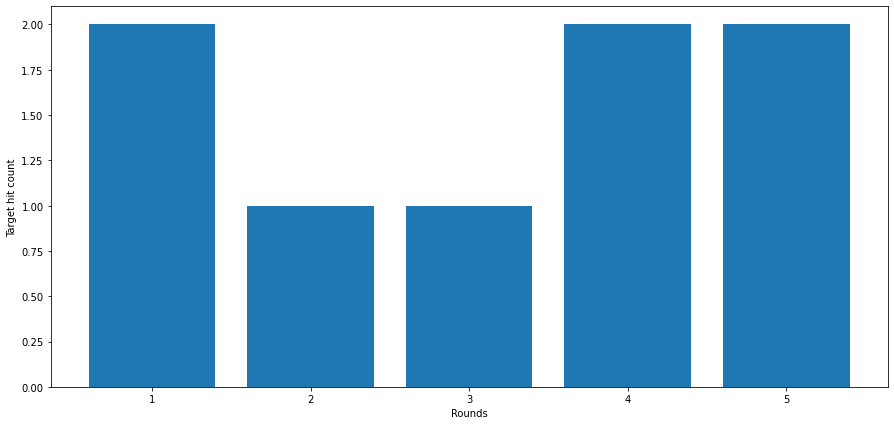

In [75]:
rounds_list = list(hit_rate_hist.keys());
print("rounds_list : ", rounds_list);
distribution_list = list(hit_rate_hist.values());
print("distribution_list : ",distribution_list )

plt.figure(figsize=(15, 7))
plt.bar(rounds_list ,distribution_list)
plt.xlabel('Rounds')
plt.ylabel('Target hit count')
plt.show()